# **DESCRIPTION**

This project consist in a forecasting of cost for different industrial supplies from a company

# **Project Develop**

## *Install Libraries*

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install openpyxl
# !pip install matplotlib
# !pip install sklearn
# !pip install lightgbm
# !pip install category_encoders

## *Import Libraries*

In [ ]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb
import joblib

from scipy.stats import boxcox

## *Import data*

Import data from an Excel file provided by the company

In [ ]:
df_raw_data = pd.read_excel("raw_data.xlsx", index_col=0)

In [ ]:
df_raw_data.head(10)

,order_date,delivery_date,supplier_name,supply_reference,unit_value,quantity
id,,,,,,
1,2019-01-10,2019-02-28,JOHN MONCRIEFF LIMITED,VID 9A/T,21.65,50.0
2,2019-01-10,2019-02-28,JOHN MONCRIEFF LIMITED,TRANSPORTE,220.00,1.0
3,2019-01-11,2019-01-18,"TC Medida y Control de Temperatura, S.A.","TP HILO TIPO A82-KX 2x0,5MM PVC",1.26,150.0
4,2019-01-11,2019-01-18,"TC Medida y Control de Temperatura, S.A.",TRANSPORTE,15.00,1.0
5,2019-01-11,2019-01-16,IBERLABO S.A.,"RA 1/4""XTU6MM C",4.60,6.0
6,2019-01-14,2019-01-25,JACQUET IBERICA S.A.,"PL 8""300X6MM C",18.50,26.0
7,2019-01-14,2019-01-25,JACQUET IBERICA S.A.,"PL 14""300X6MM CL",46.00,2.0
8,2019-01-14,2019-01-25,JACQUET IBERICA S.A.,"PL 16""300X10MM CP",93.00,4.0
9,2019-01-14,2019-01-25,JACQUET IBERICA S.A.,TRANSPORTE,22.00,1.0


## *Data Resume*

In [ ]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10731 entries, 1 to 10890
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_date        10731 non-null  datetime64[ns]
 1   delivery_date     10720 non-null  datetime64[ns]
 2   supplier_name     10731 non-null  object        
 3   supply_reference  10731 non-null  object        
 4   unit_value        10731 non-null  float64       
 5   quantity          10731 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 586.9+ KB


In [ ]:
df_raw_data.describe()

,order_date,delivery_date,unit_value,quantity
count,10731,10720,10731.000000,10731.000000
mean,2019-03-29 07:00:33.212188928,2019-05-05 06:02:08.955224064,219.373072,69.391040
min,2013-05-16 00:00:00,2013-09-05 00:00:00,0.000000,0.000000
25%,2016-09-30 00:00:00,2016-10-17 00:00:00,4.090000,2.000000
50%,2019-01-14 00:00:00,2019-02-08 00:00:00,18.000000,7.000000
75%,2021-12-09 00:00:00,2022-01-07 00:00:00,82.590000,30.000000
max,2025-02-06 00:00:00,2025-03-28 00:00:00,124970.270000,13040.000000
std,NaN,NaN,1510.502165,331.594064


Show number of rows for each product

In [ ]:
product_counts = df_raw_data['supply_reference'].value_counts()
product_counts.head(10)

,count
supply_reference,
TRANSPORTE,420
CORTE,258
TERMO BIME,155
PORTES,125
CERTIFICADO 3.1,80
PACKING,50
EXTRA COST,46
MECANIZADO VARIOS,45
CALIBRACION BIMETA,44


## *Data Engineering*

Select the item "TA 1/2"NPT-M 316/316L" which is the real product (not extra cargos) with the most number of samples

In [ ]:
df_raw_data = df_raw_data[df_raw_data['supply_reference'] == 'TA 1/2"NPT-M 316/316L']

Deleting column of product reference

In [ ]:
df_raw_data = df_raw_data.drop(columns=["supply_reference"])

Setting date columns as datetime and unit_value as float



In [ ]:
df_raw_data["delivery_date"] = pd.to_datetime(df_raw_data["delivery_date"], errors='coerce')
df_raw_data["order_date"] = pd.to_datetime(df_raw_data["order_date"], errors='coerce')
df_raw_data['unit_value'] = df_raw_data['unit_value'].astype(str).str.replace(',', '.').astype(float)

Change the order of columns in dataframe

In [ ]:
new_column_order = ["order_date", "delivery_date", "supplier_name","unit_value","quantity"]
df_raw_data = df_raw_data[new_column_order]

Sorting dataframe by order date

In [ ]:
df_raw_data = df_raw_data.sort_values(by=['order_date'])

Fill data for items not delivered with the last day of working before christmas holidays

In [ ]:
df_raw_data['delivery_date'] = df_raw_data['delivery_date'].fillna(pd.Timestamp('2024-12-20'))

Changing suppliers names to a simply version

In [ ]:
df_raw_data.replace('JD DELCORTE s.a.s.', 'DELCORTE', inplace=True)
df_raw_data.replace('SIDSA-Suministros Industrialesm', 'SIDSA', inplace=True)
df_raw_data.replace('Mecánica Egarense, S.A.', 'EGARENSE', inplace=True)

In [ ]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 5728 to 10642
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_date     33 non-null     datetime64[ns]
 1   delivery_date  33 non-null     datetime64[ns]
 2   supplier_name  33 non-null     object        
 3   unit_value     33 non-null     float64       
 4   quantity       33 non-null     float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 1.5+ KB


## *Simple Forecasting*

### Linear Regression

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


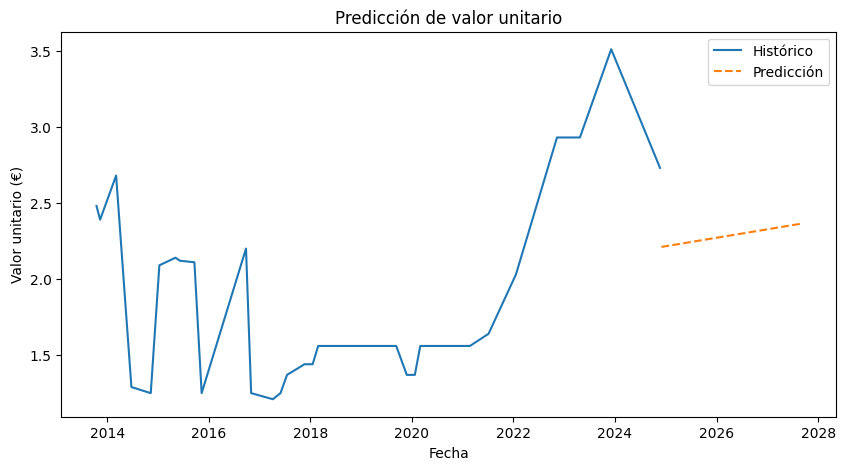

In [ ]:
df_lr = df_raw_data.copy()

# Convert dates to numbers for regression
df_lr["date_ordinal"] = df_lr["order_date"].map(pd.Timestamp.toordinal)

# Adjust regression
X = df_lr[["date_ordinal"]]
y = df_lr["unit_value"]
model = LinearRegression().fit(X, y)

# Predict future values
future_dates = pd.date_range(start=df_lr["order_date"].max(), periods=12, freq="3ME")
future_ordinals = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
future_preds = model.predict(future_ordinals)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(df_lr["order_date"], df_lr["unit_value"], label="Histórico")
plt.plot(future_dates, future_preds, "--", label="Predicción")
plt.xlabel("Fecha")
plt.ylabel("Valor unitario (€)")
plt.title("Predicción de valor unitario")
plt.legend()
plt.show()

Series shows clear structural changes and a lineal regression is not capable to fit them by design. This means that the model probably:

- Understimates the risk of further sharp rises
- Overstimates the future stability

### ARIMA and SES

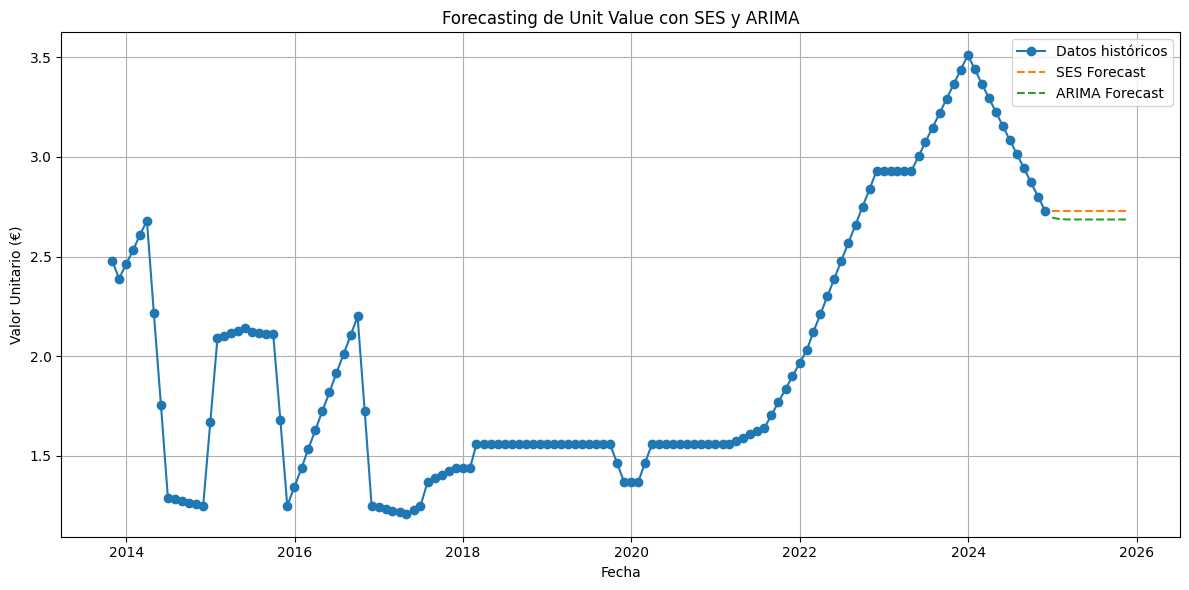

In [ ]:
df_arima_ses = df_raw_data.copy()

# Transfrom data and dataframe
df_arima_ses["order_date"] = pd.to_datetime(df_arima_ses["order_date"], dayfirst=True)
df_arima_ses.set_index("order_date", inplace=True)
df_arima_ses = df_arima_ses.sort_index()

# Reindex to monthly frequency and fill with interpolation
df_monthly = df_arima_ses[["unit_value"]].resample("ME").mean()
df_monthly["unit_value"] = df_monthly["unit_value"].interpolate(method="linear")

# Simple Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(df_monthly["unit_value"]).fit()
ses_forecast = ses_model.forecast(12)

# ARIMA
arima_model = ARIMA(df_monthly["unit_value"], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(12)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly["unit_value"], label="Datos históricos", marker='o')
plt.plot(ses_forecast.index, ses_forecast, label="SES Forecast", linestyle="--")
plt.plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.title("Forecasting de Unit Value con SES y ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Valor Unitario (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


SES smooths the recent values, so its prediction is more conservative and stable

ARIMA detects the recent upward trend and shows a sharper increase in price.

## *Complex Forecasting*

Number of real samples is too low, so if a more accurate prediction is desired, it is necessary to obtain more records.
These real records will be collected over time.

Since no more real data is available at this moment, synthetic data will be created to use ARIMAX (same as ARIMA but with exogen variables) and a multivariate regression model

### Synthetic data creation

<ipython-input-18-4101829656>:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  date_range = date_range[~date_range.isin(real_dates)]  # Exclude real dates


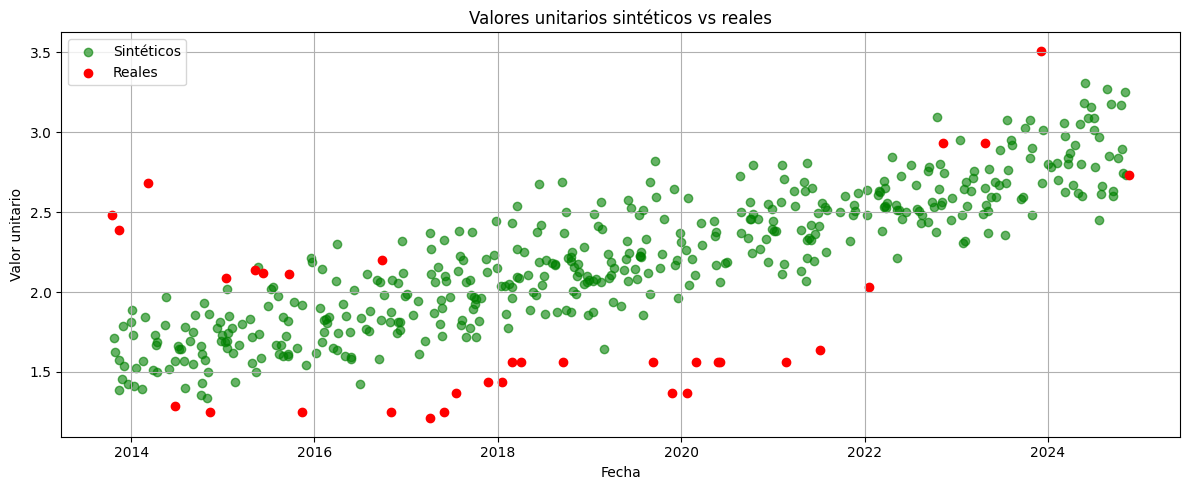

In [ ]:
# Calculate trend with regression on monthly mean
monthly_avg = df_raw_data.groupby(pd.Grouper(key='order_date', freq='ME'))['unit_value'].mean().interpolate()
X = np.arange(len(monthly_avg)).reshape(-1, 1)
y = monthly_avg.values
model = LinearRegression().fit(X, y)

# Create 450 random order dates
n_samples = 450
start_date = df_raw_data['order_date'].min()
end_date = df_raw_data['order_date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Remove real order dates from the date range
real_dates = df_raw_data['order_date'].dt.date.unique()  # Only the unique dates
date_range = date_range[~date_range.isin(real_dates)]  # Exclude real dates

# Generate unique random order dates
order_dates = np.random.choice(date_range, size=n_samples, replace=False)

# Calculate temporal position to apply trend
order_dates_sorted = np.sort(order_dates)
relative_months = ((pd.to_datetime(order_dates_sorted) - pd.to_datetime(start_date)) / pd.Timedelta(days=30)).astype(int)
relative_months = pd.Series(relative_months).clip(0, len(monthly_avg) - 1)
trend = model.predict(relative_months.values.reshape(-1, 1))

# Simulate quantities (integer values multiples of 50)
real_quantities = df_raw_data['quantity'].dropna()
min_q = max((min(real_quantities) // 50) * 50, 50) # Ensure minimum values is 50
max_q = (max(real_quantities) // 50) * 50
synthetic_quantities = np.random.choice(np.arange(min_q, max_q + 1, 50), size=n_samples)

# Simulate urgency (delivery days)
delivery_days = np.random.randint(5, 31, size=n_samples)
delivery_dates = order_dates_sorted + pd.to_timedelta(delivery_days, unit='D')

# Simulate suppliers
real_suppliers = df_raw_data['supplier_name'].dropna().unique()
synthetic_suppliers = np.random.choice(real_suppliers, size=n_samples)

# Parameters of synthetic model
alpha = 2    # Quantity impact
beta = 3    # Urgency impact
noise = np.random.normal(0, 0.15, size=n_samples)

# Calculate unit_value based on realistic logic
unit_values = trend + alpha * (1 / synthetic_quantities) + beta * (1 / delivery_days) + noise

# Adjust synthetic values to be over real minimum
scaling_factor = np.mean(df_raw_data['unit_value']) / np.mean(unit_values)
unit_values_adjusted = unit_values * scaling_factor

# Ensure that the adjusted values do not fall below the actual minimum value
unit_values_adjusted = np.clip(unit_values_adjusted, np.min(df_raw_data['unit_value']), np.max(df_raw_data['unit_value']))

# Create synthetic DataFrame
df_synthetic = pd.DataFrame({
    'order_date': order_dates_sorted,
    'delivery_date': delivery_dates,
    'supplier_name': synthetic_suppliers,
    'unit_value': unit_values,
    'quantity': synthetic_quantities,
})

# Visualization
plt.figure(figsize=(12, 5))
plt.scatter(df_synthetic['order_date'], df_synthetic['unit_value'], label="Sintéticos", color='green', alpha=0.6)
plt.scatter(df_raw_data['order_date'], df_raw_data['unit_value'], label="Reales", color='red')
plt.title("Valores unitarios sintéticos vs reales")
plt.xlabel("Fecha")
plt.ylabel("Valor unitario")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Combine real and synthetic data

In [ ]:
df_purchases = pd.concat([df_raw_data, df_synthetic], ignore_index=True)

In [ ]:
df_purchases = df_purchases.sort_values(by=['order_date'])

In [ ]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, 0 to 32
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_date     483 non-null    datetime64[ns]
 1   delivery_date  483 non-null    datetime64[ns]
 2   supplier_name  483 non-null    object        
 3   unit_value     483 non-null    float64       
 4   quantity       483 non-null    float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 22.6+ KB


In [ ]:
df_purchases.describe()

,order_date,delivery_date,unit_value,quantity
count,483,483,483.000000,483.000000
mean,2019-03-19 14:03:43.602484480,2019-04-06 09:11:33.167702016,2.188968,354.937888
min,2013-10-17 00:00:00,2013-10-18 00:00:00,1.210000,12.000000
25%,2016-08-07 12:00:00,2016-08-25 00:00:00,1.832535,200.000000
50%,2019-01-13 00:00:00,2019-01-26 00:00:00,2.178648,350.000000
75%,2021-11-20 12:00:00,2021-12-12 12:00:00,2.531206,550.000000
max,2024-11-20 00:00:00,2024-12-05 00:00:00,3.510000,725.000000
std,NaN,NaN,0.449033,202.626510


Distributions and relationships of target values

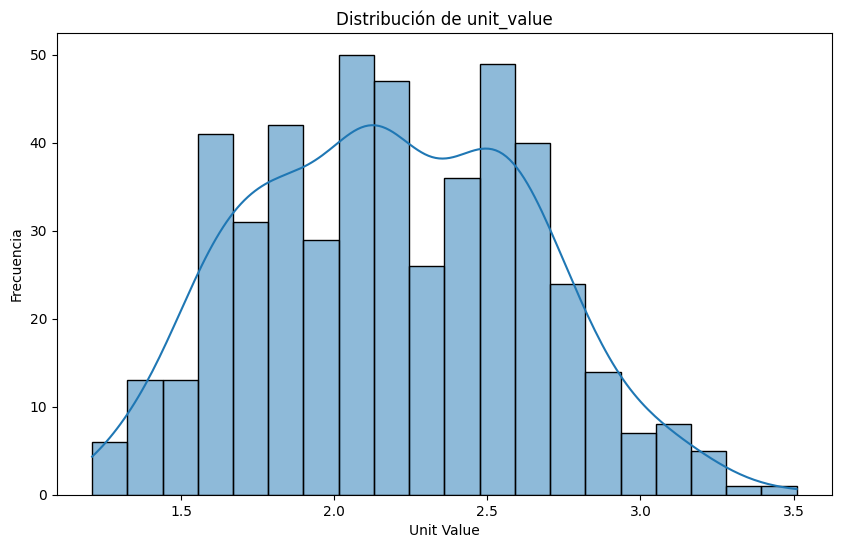

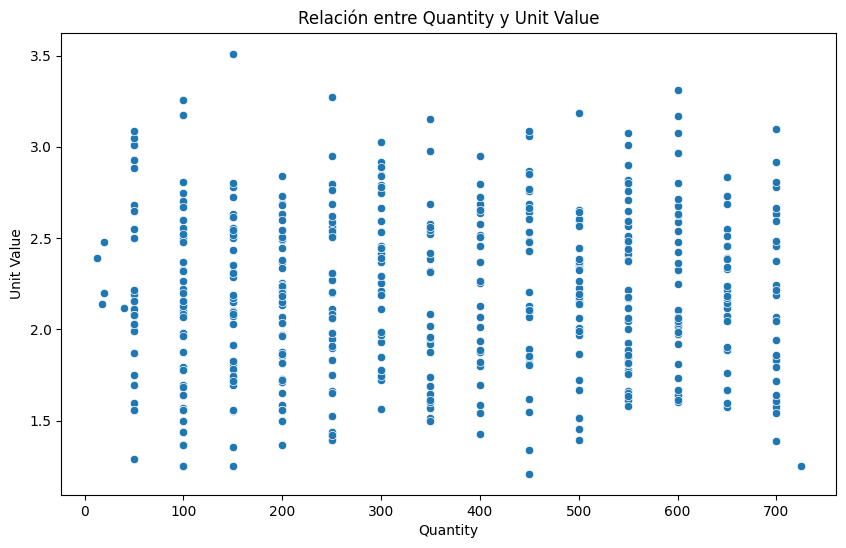

In [ ]:
# Distribution of unit_value
plt.figure(figsize=(10, 6))
sns.histplot(df_purchases['unit_value'], bins=20, kde=True)
plt.title('Distribución de unit_value')
plt.xlabel('Unit Value')
plt.ylabel('Frecuencia')
plt.show()

# Relationship betwwon quantity and unit_value
plt.figure(figsize=(10, 6))
sns.scatterplot(x='quantity', y='unit_value', data=df_purchases)
plt.title('Relación entre Quantity y Unit Value')
plt.xlabel('Quantity')
plt.ylabel('Unit Value')
plt.show()


Creation of new category based on difference between order date and delivery date

In [ ]:
df_purchases["delivery_days"] = (df_purchases["delivery_date"] - df_purchases["order_date"]).dt.days

### Forecasting with SARIMAX

Check for trend and seasonality

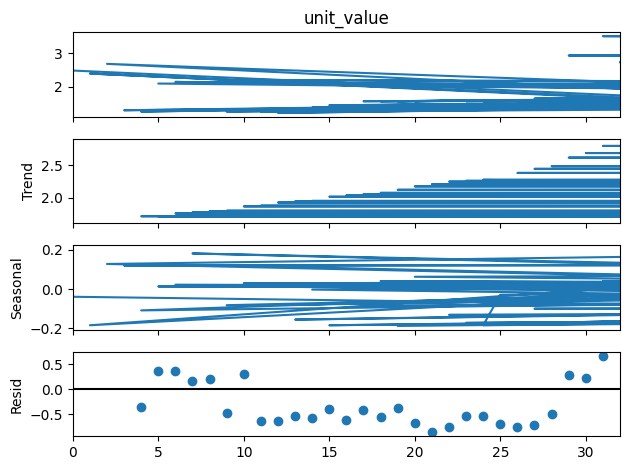

In [ ]:
result = seasonal_decompose(df_purchases['unit_value'], model='additive', period=60)

result.plot()
plt.show()

Series have an ascending trend.

Seasonal weak presence or hard to see due to noise.

Seasonal test (ADF)

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_purchases['unit_value'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.10244092127746053
p-value: 0.9662273524959801


p-value > 0.05 so series is not stationary and needs differentiation

PREPARING DATA

In [ ]:
df_sarimax = df_purchases.copy()

start_date = df_sarimax['order_date'].min()
end_date = df_sarimax['order_date'].max()
date_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Daily aggregation
daily_data = []
for date in df_sarimax['order_date'].unique():
    day_data = df_sarimax[df_sarimax['order_date'] == date]

    weighted_avg = np.average(day_data['unit_value'], weights=day_data['quantity'])

    daily_record = {
        'order_date': date,
        'unit_value': weighted_avg,
        'quantity': day_data['quantity'].sum(),
        'delivery_days': day_data['delivery_days'].mean(),
        'supplier_name': day_data['supplier_name'].mode()[0] if len(day_data['supplier_name'].mode()) > 0 else day_data['supplier_name'].iloc[0]
    }
    daily_data.append(daily_record)

daily_data = pd.DataFrame(daily_data)
daily_data = daily_data.set_index('order_date').sort_index()

# Detect big gaps
max_gap_days = 7
time_diffs = daily_data.index.to_series().diff()
large_gaps = time_diffs > pd.Timedelta(days=max_gap_days)

if large_gaps.any():
    print(f"Detectados {large_gaps.sum()} gaps > {max_gap_days} días")
    daily_data['post_gap'] = large_gaps.astype(int)
else:
    daily_data['post_gap'] = 0

Detectados 198 gaps > 7 días


FILL EMPTY VALUES

In [ ]:
daily_data['delivery_days'] = daily_data['delivery_days'].fillna(
    daily_data['delivery_days'].median()
)

CODIFICATION OF CATHEGORIAL VARIABLES

In [ ]:
le = LabelEncoder()
daily_data['supplier_encoded'] = le.fit_transform(daily_data['supplier_name'].astype(str))

DIAGNOSIS AND TRANSFORMATION OF THE DEPENDENT VARIABLE

In [ ]:
print("\nEstadísticas de unit_value:")
print(f"Skew: {daily_data['unit_value'].skew():.3f}")
print(f"Kurtosis: {daily_data['unit_value'].kurtosis():.3f}")
print(f"Rango: {daily_data['unit_value'].min():.3f} - {daily_data['unit_value'].max():.3f}")

# Detect outliers
Q1 = daily_data['unit_value'].quantile(0.25)
Q3 = daily_data['unit_value'].quantile(0.75)
IQR = Q3 - Q1
outliers = daily_data[(daily_data['unit_value'] < Q1 - 1.5*IQR) |
                     (daily_data['unit_value'] > Q3 + 1.5*IQR)]
print(f"Outliers detectados: {len(outliers)} ({len(outliers)/len(daily_data)*100:.1f}%)")


Estadísticas de unit_value:
Skew: 0.113
Kurtosis: -0.623
Rango: 1.210 - 3.510
Outliers detectados: 0 (0.0%)


BOX-COX TRANSFORMATION (NORMALIZE)

In [ ]:
if daily_data['unit_value'].min() > 0:
  try:
      unit_value_bc, lambda_val = boxcox(daily_data['unit_value'])
      # Verify box-cox
      from scipy import stats
      _, p_normal_original = stats.jarque_bera(daily_data['unit_value'])
      _, p_normal_bc = stats.jarque_bera(unit_value_bc)

      if p_normal_bc > p_normal_original:
          print(f"Box-Cox mejora normalidad (λ={lambda_val:.3f})")
          daily_data['unit_value_bc'] = unit_value_bc
          target_var = 'unit_value_bc'
          transform_used = ('boxcox', lambda_val)
      else:
          print("Box-Cox no mejora normalidad, usando datos originales")
          target_var = 'unit_value'
          transform_used = None
  except:
      target_var = 'unit_value'
      transform_used = None
else:
  target_var = 'unit_value'
  transform_used = None

Box-Cox no mejora normalidad, usando datos originales


EXOGENOUS VARIABLE SCALING

In [ ]:
scaler = StandardScaler()
exog_vars = ['quantity', 'delivery_days', 'supplier_encoded']
daily_data[exog_vars] = scaler.fit_transform(daily_data[exog_vars])

# Exogen Variables
exog = daily_data[exog_vars]

SARIMAX MODEL

In [ ]:
print("\n=== MODELO SARIMAX CORREGIDO ===")

y = daily_data[target_var]
exog = daily_data[exog_vars]
seasonal_period = None

# Auto-detect seasonality if not specified
if seasonal_period is None:
    # Search dominant periodicity (7, 30, 90 typical days)
    from scipy.fft import fft
    n = len(y)
    freqs = np.fft.fftfreq(n)
    fft_vals = np.abs(fft(y - y.mean()))

    # Search dominant frequencies
    peak_idx = np.argsort(fft_vals[1:n//2])[-3:]  # Top 3 frequencies
    periods = [int(1/freqs[i+1]) for i in peak_idx if freqs[i+1] > 0]
    periods = [p for p in periods if 7 <= p <= 365]  # Filter logic ranges

    seasonal_period = periods[0] if periods else 7
    print(f"Periodo estacional detectado: {seasonal_period} días")

# SARIMAX setups to different volatility levels
configs = [
    {'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 0)},
    {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, seasonal_period)},
    {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, seasonal_period)},
]

best_model = None
best_aic = np.inf

for config in configs:
    try:
        model = SARIMAX(
            y,
            exog=exog,
            **config,
            trend='ct',  # Constant + trend
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=100)

        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_model = fitted_model
            best_config = config

    except Exception as e:
        print(f"Error con configuración {config}: {e}")
        continue

if best_model is None:
    raise ValueError("No se pudo ajustar ningún modelo SARIMAX")

print(f"Mejor modelo: {best_config}, AIC: {best_aic:.2f}")



=== MODELO SARIMAX CORREGIDO ===
Periodo estacional detectado: 161 días


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mejor modelo: {'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 0)}, AIC: -36.32


MODEL SUMMARY

In [ ]:
print("\n=== RESUMEN DEL MEJOR MODELO ===")
print(best_model.summary())


=== RESUMEN DEL MEJOR MODELO ===
                               SARIMAX Results                                
Dep. Variable:             unit_value   No. Observations:                  483
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  26.161
Date:                Sat, 14 Jun 2025   AIC                            -36.321
Time:                        07:38:42   BIC                             -2.931
Sample:                             0   HQIC                           -23.196
                                - 483                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0007      0.007      0.100      0.920      -0.013       0.014
drift              8.75e-07   2.46e-05      0.036      0.972   -4.74e-05    4.9

RESIDUALS DIAGNOSIS

In [ ]:
residuals = best_model.resid

print("\n=== DIAGNÓSTICOS DE RESIDUOS ===")
# Jarque-Bera test
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuals)
print(f"Jarque-Bera p-value: {jb_pvalue:.6f}")

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"Ljung-Box p-value (lag 10): {lb_result['lb_pvalue'].iloc[-1]:.6f}")

# Heteroskedasticity test
from statsmodels.stats.diagnostic import het_breuschpagan
try:
    exog = best_model.model.exog if hasattr(best_model.model, "exog") else None
    if exog is not None:
        bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, exog)
        print(f"Breusch-Pagan p-value: {bp_pvalue:.6f}")
    else:
        print("Breusch-Pagan: No hay variables exógenas para el test.")
except Exception as e:
    print(f"No se pudo calcular test de heteroscedasticidad: {e}")

# Residuals statistics
print(f"Skew de residuos: {residuals.skew():.3f}")
print(f"Kurtosis de residuos: {residuals.kurtosis():.3f}")
print(f"Media de residuos: {residuals.mean():.6f}")
print(f"Std de residuos: {residuals.std():.6f}")



=== DIAGNÓSTICOS DE RESIDUOS ===
Jarque-Bera p-value: 0.000000
Ljung-Box p-value (lag 10): 0.003913
No se pudo calcular test de heteroscedasticidad: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.
Skew de residuos: 0.957
Kurtosis de residuos: 12.141
Media de residuos: 0.009056
Std de residuos: 0.249907


DIAGNOSIS GRAPHS

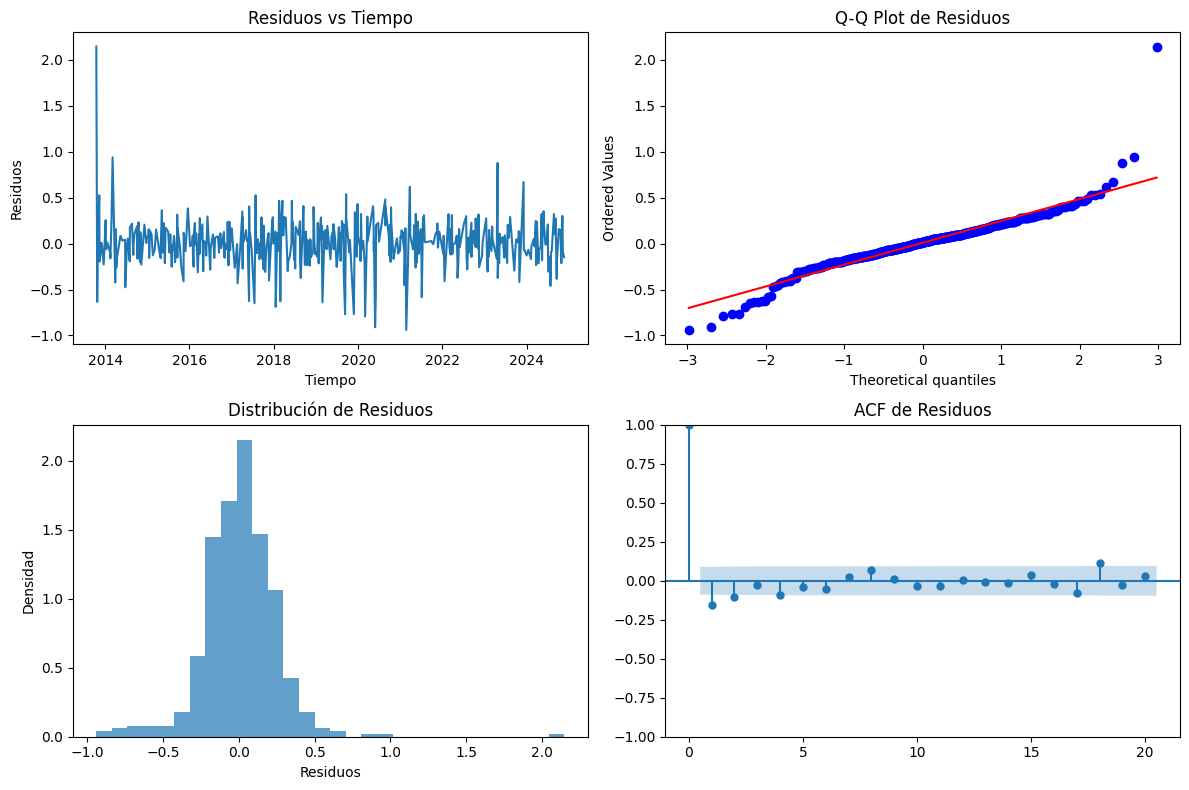

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals vs time
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuos vs Tiempo')
axes[0,0].set_xlabel('Tiempo')
axes[0,0].set_ylabel('Residuos')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot de Residuos')

# Residuals Histogram
axes[1,0].hist(residuals, bins=30, density=True, alpha=0.7)
axes[1,0].set_title('Distribución de Residuos')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Densidad')

# Residuals ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=axes[1,1], lags=20)
axes[1,1].set_title('ACF de Residuos')

plt.tight_layout()
plt.show()

FORECASTING

In [ ]:
model = best_model

forecast_steps = 30
exog_forecast = np.tile(daily_data[exog_vars].iloc[-1].values, (forecast_steps, 1))

forecast = best_model.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_df = pd.DataFrame({
    'forecast': forecast.predicted_mean,
    'lower_ci': forecast.conf_int().iloc[:, 0],
    'upper_ci': forecast.conf_int().iloc[:, 1]
})

# Index with dates for forecast
last_date = daily_data.index[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)
forecast_df.index = forecast_dates

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


GRAPH RESULTS

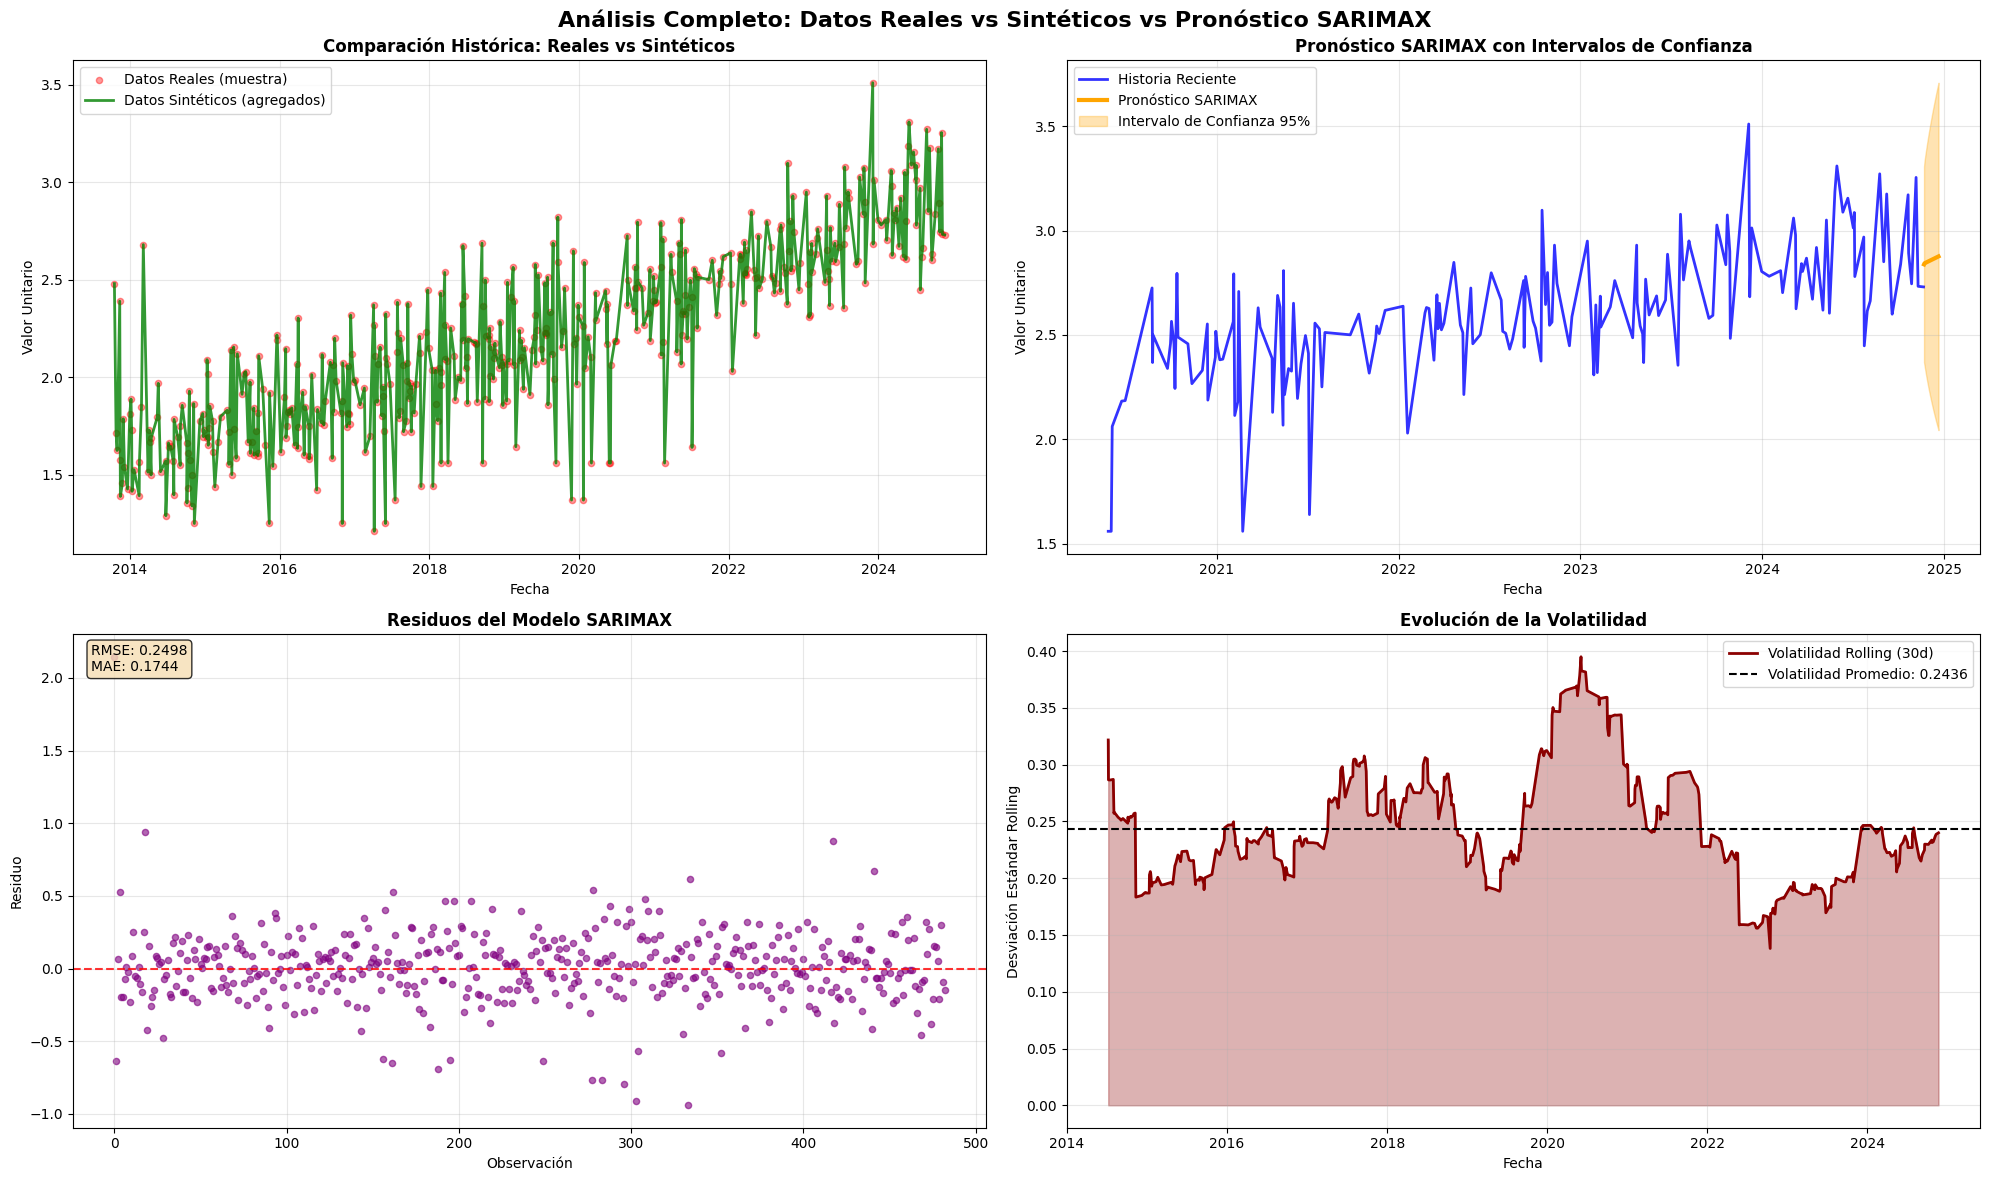

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análisis Completo: Datos Reales vs Sintéticos vs Pronóstico SARIMAX',
              fontsize=16, fontweight='bold')

# ===== Graph 1: Historical Comparison =====
ax1 = axes[0, 0]

# Original data
sample_size = min(1000, len(df_sarimax))
sample_data = df_sarimax.sample(n=sample_size, random_state=42).sort_values('order_date')

ax1.scatter(sample_data['order_date'], sample_data['unit_value'],
            alpha=0.4, s=20, color='red', label='Datos Reales (muestra)', zorder=1)

# Daily aggregate
ax1.plot(daily_data.index,
          daily_data['unit_value'] if 'unit_value' in daily_data.columns
          else daily_data.iloc[:, 0],
          color='green', linewidth=2, alpha=0.8, label='Datos Sintéticos (agregados)')

ax1.set_title('Comparación Histórica: Reales vs Sintéticos', fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Valor Unitario')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===== Graph 2: Forecasting With Intervals =====
ax2 = axes[0, 1]

# Recent history (last 6 months)
recent_history = daily_data.tail(180)
target_col = 'unit_value' if 'unit_value' in recent_history.columns else recent_history.columns[0]

ax2.plot(recent_history.index, recent_history[target_col],
          color='blue', linewidth=2, label='Historia Reciente', alpha=0.8)

# Forecasting
ax2.plot(forecast_df.index, forecast_df['forecast'],
          color='orange', linewidth=3, label='Pronóstico SARIMAX')

# Confidence intervals
ax2.fill_between(forecast_df.index,
                  forecast_df['lower_ci'],
                  forecast_df['upper_ci'],
                  alpha=0.3, color='orange', label='Intervalo de Confianza 95%')

ax2.set_title('Pronóstico SARIMAX con Intervalos de Confianza', fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Valor Unitario')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ===== Graph 3: Model Residuals =====
ax3 = axes[1, 0]

residuals = model.resid
ax3.scatter(range(len(residuals)), residuals, alpha=0.6, s=20, color='purple')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax3.set_title('Residuos del Modelo SARIMAX', fontweight='bold')
ax3.set_xlabel('Observación')
ax3.set_ylabel('Residuo')
ax3.grid(True, alpha=0.3)

# Residuals statistics
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
ax3.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}',
          transform=ax3.transAxes, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ===== Graph 4: Volatility Distribution =====
ax4 = axes[1, 1]

# Calculate volatility rolling
rolling_window = 30
if len(daily_data) > rolling_window:
    rolling_std = daily_data[target_col].rolling(window=rolling_window).std()

    ax4.plot(rolling_std.index, rolling_std,
            color='darkred', linewidth=2, label=f'Volatilidad Rolling ({rolling_window}d)')
    ax4.fill_between(rolling_std.index, 0, rolling_std, alpha=0.3, color='darkred')

    # Average volatility line
    avg_volatility = rolling_std.mean()
    ax4.axhline(y=avg_volatility, color='black', linestyle='--',
                label=f'Volatilidad Promedio: {avg_volatility:.4f}')

    ax4.set_title('Evolución de la Volatilidad', fontweight='bold')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Desviación Estándar Rolling')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Datos insuficientes\npara calcular volatilidad',
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Volatilidad - Datos Insuficientes', fontweight='bold')

plt.tight_layout()

1. Comparación Histórica: Reales vs Sintéticos (Historic Comparison: Real vs Synthetic)
Compare temporal evolution of unit_value between real and synthetic data. Ascending trend is clear in both sets

2. Pronóstico SARIMAX con Intervalos de Confianza (SARIMAX forecasting with confidence intervals)
Show forecasting of unit_value with SARIMAX and its uncertainty. SARIMAX model provides resonable results with low level of uncertainty.

3. Residuos del Modelo SARIMAX (SARIMAX model residuals)
Evaluate if model errors are small and randomly distributed. Reasiduals are near to zero with no clear pattern. There is no cycles nor trends in errors

4. Evolución de la Volatilidad (Volatility evolution)
Shows unit_value variability over time. Series has had high inestability moments, but now it shows contained volatility

### Forecasting with other models (Random Forest)

In [ ]:
feature_names = []
label_encoders = {}

In [ ]:
def prepare_data(df, label_encoders=None, min_date=None):
  df_features = df.copy()

  if label_encoders is None:
    label_encoders = {}

  if min_date is None:
    min_date = df_features['order_date'].min()

  # Temporary Features
  df_features['year'] = df_features['order_date'].dt.year
  df_features['month'] = df_features['order_date'].dt.month
  df_features['day'] = df_features['order_date'].dt.day
  df_features['weekday'] = df_features['order_date'].dt.weekday
  df_features['quarter'] = df_features['order_date'].dt.quarter
  df_features['day_of_year'] = df_features['order_date'].dt.dayofyear

  # Cycle Features (seasonality)
  df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
  df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
  df_features['day_sin'] = np.sin(2 * np.pi * df_features['day'] / 31)
  df_features['day_cos'] = np.cos(2 * np.pi * df_features['day'] / 31)

  # Urgency Features
  df_features['delivery_days'] = (df_features['delivery_date'] - df_features['order_date']).dt.days
  df_features['urgency_score'] = 1 / df_features['delivery_days']  # more urgently = more score

  # Quantity Features
  df_features['quantity_log'] = np.log(df_features['quantity'])
  df_features['quantity_inv'] = 1 / df_features['quantity']

  # Supplier Features
  if 'supplier_name' in df_features.columns:
      if 'supplier_name' not in label_encoders:
          label_encoders['supplier_name'] = LabelEncoder()
          df_features['supplier_encoded'] = label_encoders['supplier_name'].fit_transform(df_features['supplier_name'])
      else:
          df_features['supplier_encoded'] = label_encoders['supplier_name'].transform(df_features['supplier_name'])

  # Temporary Trend Features (days since start)
  df_features['days_since_start'] = (df_features['order_date'] - min_date).dt.days
  df_features['months_since_start'] = df_features['days_since_start'] / 30.44  # Days per month average

  # Select features for model
  feature_columns = [
      'year', 'month', 'day', 'weekday', 'quarter', 'day_of_year',
      'month_sin', 'month_cos', 'day_sin', 'day_cos',
      'delivery_days', 'urgency_score', 'quantity', 'quantity_log', 'quantity_inv',
      'supplier_encoded', 'days_since_start', 'months_since_start'
  ]

  # Filter columns that exist
  available_features = [col for col in feature_columns if col in df_features.columns]
  feature_names = available_features

  X = df_features[available_features]

  return X, df_features, feature_names, label_encoders

In [ ]:
def tune_hyperparameters(X_train, y_train, cv=5, conservative=False, anti_overfitting=False):
  """
  Optimizar hiperparámetros del Random Forest
  """
  if anti_overfitting:
      # Grid ultra-conservador para datos sintéticos
      param_grid = {
          'n_estimators': [50, 100, 150],
          'max_depth': [4, 6, 8, 10],
          'min_samples_split': [10, 15, 20, 25],
          'min_samples_leaf': [5, 8, 12, 15],
          'max_features': [0.3, 0.4, 0.5, 'sqrt']
      }
  elif conservative:
      # Grid más conservador para evitar overfitting
      param_grid = {
          'n_estimators': [100, 150, 200],
          'max_depth': [8, 12, 16, 20],
          'min_samples_split': [5, 10, 15],
          'min_samples_leaf': [2, 4, 6],
          'max_features': ['sqrt', 'log2', 0.5]
      }
  else:
      # Grid original (más agresivo)
      param_grid = {
          'n_estimators': [100, 200, 300],
          'max_depth': [10, 20, 30, None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['sqrt', 'log2', None]
      }

  rf = RandomForestRegressor(random_state=42, n_jobs=-1)
  grid_search = GridSearchCV(
      rf, param_grid, cv=cv,
      scoring='neg_mean_squared_error',
      n_jobs=-1, verbose=1
  )

  grid_search.fit(X_train, y_train)
  return grid_search.best_params_

TRAIN MODEL

In [ ]:
X, df_prepared, feature_names, label_encoders = prepare_data(df_purchases)
y = df_prepared['unit_value']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Fine tuning
best_params = tune_hyperparameters(X_train, y_train, conservative=False, anti_overfitting=True)
print(f"Mejores parámetros: {best_params}")

# Train final mod
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metrics = {
    'train': {
        'mae': mean_absolute_error(y_train, y_pred_train),
        'mse': mean_squared_error(y_train, y_pred_train),
        'rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'r2': r2_score(y_train, y_pred_train)
    },
    'test': {
        'mae': mean_absolute_error(y_test, y_pred_test),
        'mse': mean_squared_error(y_test, y_pred_test),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'r2': r2_score(y_test, y_pred_test)
    }
}

train_r2 = metrics['train']['r2']
test_r2 = metrics['test']['r2']
overfitting_gap = train_r2 - test_r2

print(f"\n--- Análisis de Overfitting ---")
print(f"R² Train: {train_r2:.4f}")
print(f"R² Test:  {test_r2:.4f}")
print(f"Gap:      {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print("⚠️  POSIBLE OVERFITTING detectado!")
    print("Considera usar parámetros más conservadores:")
    print("- max_depth: 10-20")
    print("- min_samples_leaf: 2-5")
    print("- min_samples_split: 5-10")
elif overfitting_gap < 0.02:
    print("✅ Sin signos de overfitting")
else:
    print("ℹ️  Overfitting leve, dentro del rango normal")

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

--- Análisis de Overfitting ---
R² Train: 0.8799
R² Test:  0.7550
Gap:      0.1249
⚠️  POSIBLE OVERFITTING detectado!
Considera usar parámetros más conservadores:
- max_depth: 10-20
- min_samples_leaf: 2-5
- min_samples_split: 5-10


Overfitting can occur for the following  reasons:
*   Regular syntetic data
*   Low noise
*   Redundant Features

FEATURE IMPORTANCE

In [ ]:
if model is None:
    raise ValueError("El modelo debe ser entrenado primero")

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
17,months_since_start,0.364737
16,days_since_start,0.285288
0,year,0.167210
10,delivery_days,0.055415
11,urgency_score,0.050793
9,day_cos,0.007929
3,weekday,0.007636
5,day_of_year,0.007609
2,day,0.007480
12,quantity,0.007244


PLOT RESULTS

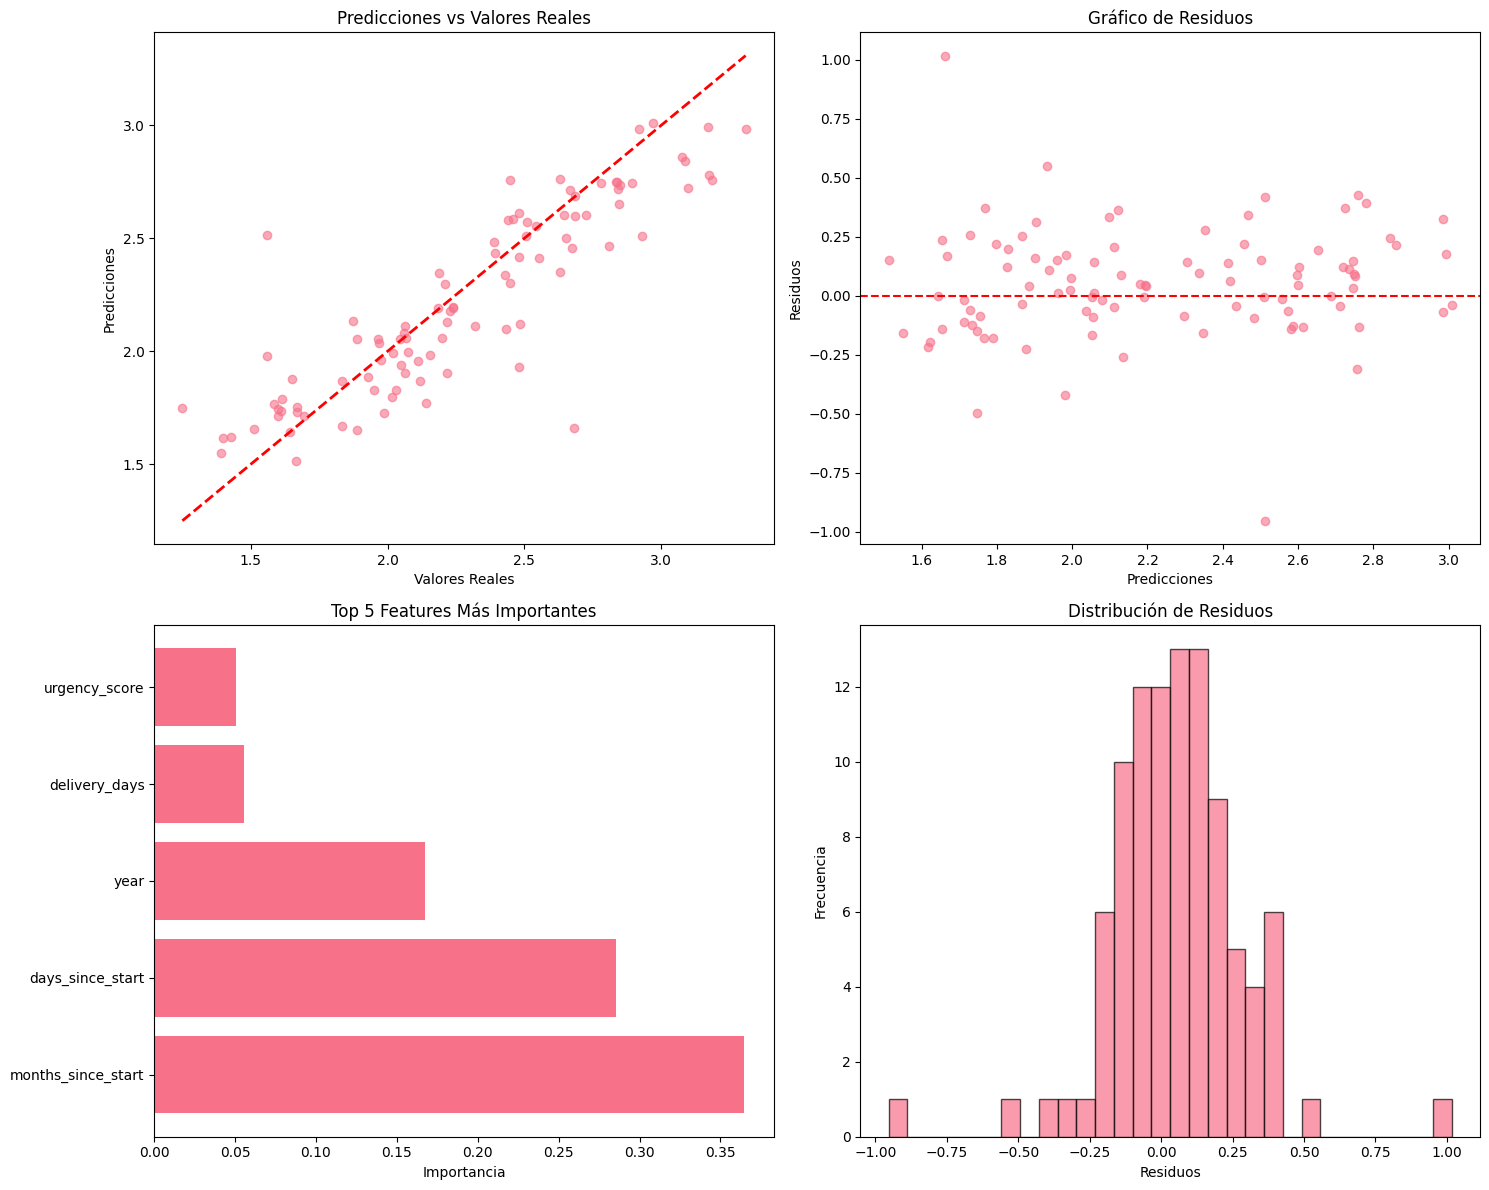

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicts vs Real Values
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Predicciones vs Valores Reales')

# 2. Residuals
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicciones')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].set_title('Gráfico de Residuos')

# 3. Feature Importance
top_features = importance_df.head(5)
axes[1, 0].barh(top_features['feature'], top_features['importance'])
axes[1, 0].set_xlabel('Importancia')
axes[1, 0].set_title('Top 5 Features Más Importantes')

# 4. Residuals Distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Residuos')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Residuos')

plt.tight_layout()
plt.show()

1. Predicciones vs Valores Reales (Predictions vs Real values )
Results are cloes to the line, so there is good predictive ability, but there is some scatter suggesting moderate errors

2. Gráfico de residuos (Residuals graph)
Shows resiudals against predictions. They are centered to zero with some outliers near to 1. There is no systematic pattern.

3. Top 5 Features más importantes (Top 5 more important features)
It shows the 5 more important features in the model. Elapsed time is the most influential factor in the prediction, which is common in time series models of prices or trends.

4. Distribución de residuos (Residuals Distribution)
Symmetrical distribution centered on zero. Slightly right biased. This shows that there is no a significant systematic bias

FORECASTING

In [ ]:
last_date = df_purchases['order_date'].max()
days_ahead=360
delivery_days=[7, 14, 21, 28]
suppliers=['DELCORTE', 'SIDSA', 'EGARENSE']

if model is None:
    raise ValueError("El modelo debe ser entrenado primero")

# Generate future dates
all_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days_ahead, freq='D')

weekday_dates = all_dates[all_dates.dayofweek < 5]

# Add aleatory gaps
np.random.seed(42)
has_order = np.random.random(len(weekday_dates)) > 0.4 # Only 60% of workdays have orders

future_dates = weekday_dates[has_order]

# Create forecasting DataFrame
n_predictions = len(future_dates)
future_df = pd.DataFrame({
    'order_date': future_dates,
    'delivery_date': future_dates + pd.to_timedelta(np.random.choice(delivery_days, size=n_predictions), unit='D'),
    'quantity': np.random.choice(range(50,500,10), size=n_predictions),
    'supplier_name': np.random.choice(suppliers, size=n_predictions)
})

# Prepare features
X_future, _, _, _, = prepare_data(future_df, label_encoders, df_prepared['order_date'].min())

# Predictions
predictions = model.predict(X_future)

future_df['predicted_unit_value'] = predictions

GRAPH INITIAL DATA AND FORECASTING

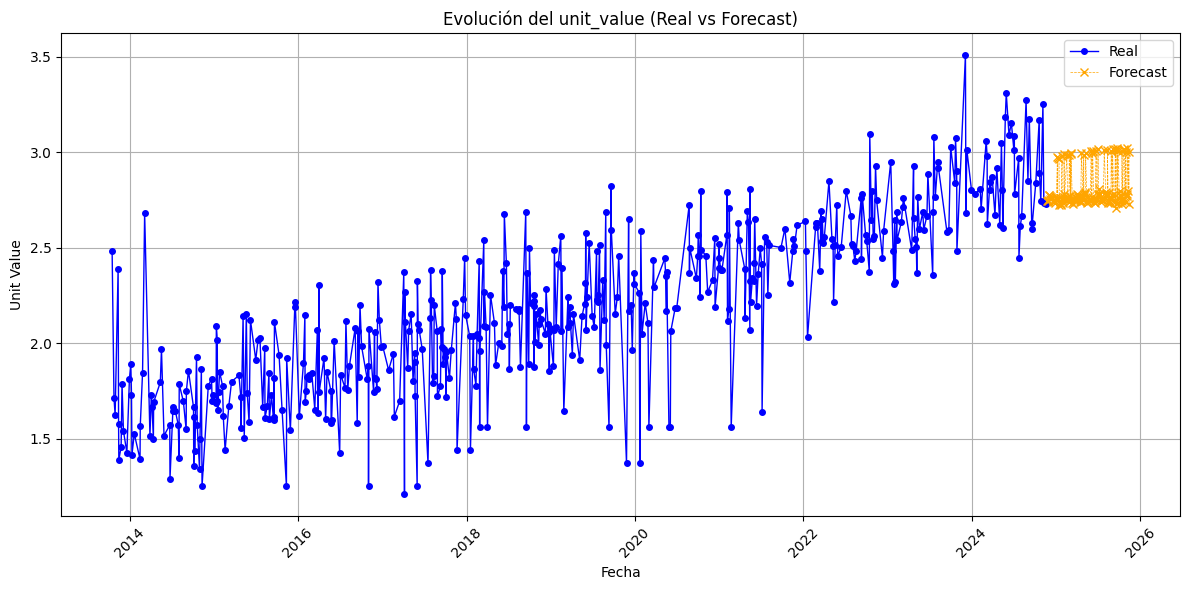

In [ ]:
import matplotlib.pyplot as plt

# Sorting dates
df_real_sorted = df_purchases.sort_values('order_date')
df_forecast_sorted = future_df.sort_values('order_date')

plt.figure(figsize=(12, 6))

# Real data
plt.plot(df_real_sorted['order_date'], df_real_sorted['unit_value'],
         label='Real', color='blue', marker='o', markersize=4, linewidth=1)

# Forecasting data
plt.plot(df_forecast_sorted['order_date'], df_forecast_sorted['predicted_unit_value'],
         label='Forecast', color='orange', linestyle='--', marker='x', markersize=6, linewidth=0.5)

# Graph setup
plt.title('Evolución del unit_value (Real vs Forecast)')
plt.xlabel('Fecha')
plt.ylabel('Unit Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graphs shows the known data (blue) ande the prediction of the model (orange).

Model captures the ascending trend, but the results are oscillating between 3 and 2,75 approximately.

So this model has a good prediction of the average level in the future. It seems to be understimating the variability of the unit value, perhaps due to existing overfitting